In [74]:
import numpy as np
from numpy.random import RandomState

import pandas as pd

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import distributions as td
from torch.nn import functional as F

## Let's show how a single desirability score can go off the rails, even in a simple situation

### Demographic assumptions

Let's assume we have two types of people - Punks and Mods.  Let's list out core feature of note about the demos:
+ Mods tend to not like punks, and vice versa.  
+ There are many more mods than punks.  
+ Punks are more likely to have a wider diversity of people they'd find attractive in their clique
+ we are currently **NOT considering gender effects**, as we want to highlight the importance of considering groups/cliques/whatever you want to call them

### Ranking assumptions

+ left swipe makes it go down, right swipe makes it go up
+ ...really need some more ideas here, look up ELO or a blog later

+ okay looks like hinge uses the [Gale-Shapley](https://github.com/Vishal-Kancharla/Gale-Shapley-Algorithm#pseudocode-) algorithm, or at least a variant of it.  we will use a small version of it for show

## Generate synthetic dataset

In [84]:
# ---
POP = dict(
    MOD = 0.9,
    PUNK = 0.1,
)

P_REJECT = dict(
    MOD = dict(
        MOD = 0.0,
        PUNK = 0.8,
    ),
    PUNK = dict(
        MOD = 0.95,
        PUNK = 0.0,
    ),
)

SCALE = dict(
    MOD = 1.,
    PUNK = 2.,
)

SEED = None
SMALL = 1e-8

# ---
rng = RandomState(SEED)
# ---


def sigmoid(x: float) -> float:
    return 1. / (1. + np.exp(-x))



def p_right_ingroup(
    swiper_score: float, 
    swipee_score: float, 
    swiper_scale: float) -> float:
    """
    return liklihood of swiping given scores and swiper's 
    tolerance of lower scores (swiper scale).
    does this by adding positive stochastic noise to swipee score, scaled on swiper's tolerance
    
    + NOT returning a swipe - returning a PROB of swipe, which adds a third step of stochasticity
        + can treat as deterministic by simply swiping on whether this score is gt or lt 0.
    """
    to_beat = swipee_score + abs(rng.normal(0., swiper_scale))
    return sigmoid(to_beat - swiper_score)
    

def p_right_outgroup(
    swiper_score: float,
    swipee_score: float,
    swiper_scale: float,
    p_reject_outgroup: float,) -> float:
    """
    out of group will be treated simply as a chance to reject independent of scores.
    if not rejected due to group, will be scored same as if in in-group
    """
    if rng.uniform() < p_reject_outgroup:
        p = 0.
    else:
        p = p_right_ingroup(
            swiper_score = swiper_score,
            swipee_score = swipee_score,
            swiper_scale = swiper_scale,
            )
    return p


def p_right(
    swiper_group: str,
    swipee_group: str,
    
    swiper_score: float,
    swipee_score: float,
    ) -> float:
    
    """
    pass in groups and scores and return liklihood of a right swipe.
    note the stochastic steps:
      + p_reject_outgroup (will be 0. if swiper and swipee groups the same)
      + positive noise added to swipee score (scale of noise dependent on swiper_group)
      + NOT returning a swipe - returning a prob of swipe, which adds a third step of stochasticity
        + can treat as deterministic by simply swiping on whether this score is gt or lt 0.
    """
    
    return p_right_outgroup(
        swiper_score = swiper_score,
        swipee_score = swipee_score,

        swiper_scale = SCALE[swiper_group],
        
        p_reject_outgroup = P_REJECT[swiper_group][swipee_group],
    )

def swipe(
    swiper_group: str,
    swipee_group: str,
    
    swiper_score: float,
    swipee_score: float,) -> bool:
    """return a left (False) or right (True) swipe"""
    p = p_right(
        swiper_group = swiper_group,
        swipee_group = swiper_group,
    
        swiper_score = swiper_score,
        swipee_score = swipee_score,
    )
    
    return rng.rand() < p


## draw population
def sample_population(n: int):
    """
    draw a population and return as a well-organized dataframe w score and group,
    sorted by score
    """
    n_punk = int(n * POP["PUNK"])
    n_mod = n - n_punk
    
    punk_scores = rng.normal(0., 1., size = n_punk).tolist()
    mod_scores = rng.normal(0., 1., size = n_mod).tolist()
    
    pdf = pd.DataFrame([punk_scores, ["PUNK"] * n_punk])
    mdf = pd.DataFrame([mod_scores, ["MOD"] * n_mod])
    
    df = pd.concat([pdf.T, mdf.T])\
            .rename(columns={0: "score", 1: "group"})\
            .sort_values(by="score", ascending=False,)\
            .reset_index(drop=True)
    
    return df


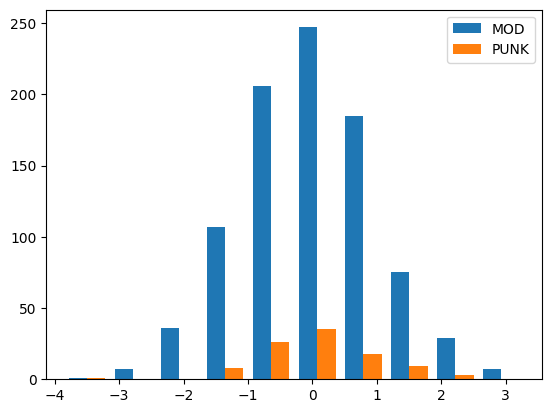

In [85]:
# draw population and ensure we have the demos we expected

N = 1000
df = sample_population(n = N)

groups = df.group.unique()

plt.hist(
    [df.loc[df.group == x, 'score'] for x in groups],
    label=groups, 
    bins=N//100)

plt.legend()
plt.show()

In [86]:
# we will do something like the hinge algorithm.  the question is what is stabilizes on recommending

# we'll start by choosing someone with the highest joint liklihood of both swiping yes
swiper = df.iloc[0]

i_candidates = rng.permutation(df.shape[0])[:100]

candidates = df.iloc[i_candidates]

In [87]:
swiper, candidates

(score    3.289194
 group         MOD
 Name: 0, dtype: object,
         score group
 608 -0.283593   MOD
 751 -0.697978   MOD
 895 -1.295496   MOD
 995 -2.737957   MOD
 733 -0.629705  PUNK
 ..        ...   ...
 571 -0.207334   MOD
 525 -0.085545   MOD
 316  0.445236   MOD
 444  0.105851   MOD
 920 -1.442394  PUNK
 
 [100 rows x 2 columns])

In [118]:
def p_match(swipee):
    p_swiper = p_right(
        swiper_score = swiper.score,
        swipee_score = swipee.score,
        swiper_group = swiper.group,
        swipee_group = swipee.group,
    )
    p_swipee = p_right(
        swiper_score = swipee.score,
        swipee_score = swiper.score,
        swiper_group = swipee.group,
        swipee_group = swiper.group,
    )
    
    return dict(
        p_match = p_swiper * p_swipee,
        
        p_swiper = p_swiper,
        p_swipee = p_swipee,
        
        swiper_score = swiper.score,
        swipee_score = swipee.score,
        
        swiper_group = swiper.group,
        swipee_group = swipee.group,
        
        swiper_id = swiper.name,
        swipee_id = swipee.name,
    )

match_scores = pd.DataFrame(
    candidates.apply(p_match, axis=1).tolist())\
    .sort_values(by="p_match", ascending=False,)

In [119]:
match_scores

,p_match,p_swiper,p_swipee,swiper_score,swipee_score,swiper_group,swipee_group,swiper_id,swipee_id
77,0.456841,0.551844,0.827845,3.289194,2.692414,MOD,MOD,0,5
16,0.424281,0.449440,0.944022,3.289194,0.716643,MOD,MOD,0,216
15,0.389970,0.576808,0.676084,3.289194,3.162173,MOD,MOD,0,1
43,0.354446,0.402543,0.880519,3.289194,1.387890,MOD,MOD,0,85
78,0.350617,0.355534,0.986171,3.289194,0.059990,MOD,MOD,0,465
...,...,...,...,...,...,...,...,...,...
32,0.000000,0.000000,0.000000,3.289194,-0.093200,MOD,PUNK,0,529
35,0.000000,0.000000,0.000000,3.289194,-0.453824,MOD,PUNK,0,673
52,0.000000,0.000000,0.000000,3.289194,1.778968,MOD,PUNK,0,44
40,0.000000,0.000000,0.000000,3.289194,0.206865,MOD,PUNK,0,406


## Inferring desirability score

this is an attempt to infer scores.  it is NOT an attempt to recreate a particular algorithm.  it's meant to capture the following features of a scoring algorithm though, whatever it is:

+ everyone gets a single scalar "desirability" score
+ given two people, the person with the higher score has a higher probability of a right swipe on expectation
+ the higher someone is vs you, the more likely you are to swipe right.
+ the lower someone is vs you, the more likely you are to swipe left.

### current implementation
**NOTE**: read the alg below first, as this will probably be out of date.  just a notepad for my general direction atm

1. everyone swipes given "true" scores and groups
2. rank simply by percentage that swiped you
3. bin ranks
4. run again, sampling swipes for you normally centered on your current bin
5. move up or down depending how you did in your bin